# Classifying real vs. fake photons from $tt\gamma$, $t\bar{t}$ events

In [1]:
from coffea import hist, util

import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=True):
        
        self.isMC = isMC

        # Declare axes
        dataset_axis = hist.Cat("dataset","Dataset")

        photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
        photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
        photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
        photon_reliso_all_axis = hist.Bin("reliso","photon pfRelIso03_all", 40, -0.5, 6)
        photon_reliso_chg_axis = hist.Bin("reliso","photon pfRelIso03_chg", 40, -0.5, 6)
        photon_sieie_axis = hist.Bin("sieie","photon sigma I eta I eta", 40, 0, 0.05)
        photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
        photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
        photon_count_axis = hist.Bin("count","Photon number",12,-1,10)

        deltar_axis = hist.Bin("deltar","$\Delta R$", 50, -0.5, 4)

        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",40,-1,15)
        
        
        # Accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            
            'photon_pt': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_eta': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_phi': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_sieie': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_r9': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_hoe': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_count': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(0,))),
            'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            
            ## histograms for features
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis),
            'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis),
            'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis),
            'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis),
            'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis),
            'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis),
            'photon_count_hist': hist.Hist("Counts", dataset_axis, photon_count_axis),
            
            'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, deltar_axis),
            'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, deltar_axis),
            
            'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4
                              )
        tightEle = electrons[electronSelectTight]
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed)
                       )
        tightPhotons = photons[photonSelect]
        
        
        ## delta R using nearest
        phoMu, phoMuDR   = tightPhotons.nearest(tightMuons,return_metric=True)
        phoJet, phoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0))
                          #(ak.num(tightPhotons)==1))

        
        # Fill histograms
        output['photon_pt_hist'].fill(dataset=dataset,
                                      pt=ak.flatten(tightPhotons[eventSelection].pt))
        output['photon_eta_hist'].fill(dataset=dataset,
                                      eta=ak.flatten(tightPhotons[eventSelection].eta))
        output['photon_phi_hist'].fill(dataset=dataset,
                                      phi=ak.flatten(tightPhotons[eventSelection].phi))
        output['photon_reliso_all_hist'].fill(dataset=dataset,
                                         reliso=ak.flatten(tightPhotons[eventSelection].pfRelIso03_all))
        output['photon_reliso_chg_hist'].fill(dataset=dataset,
                                         reliso=ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg))
        output['photon_sieie_hist'].fill(dataset=dataset,
                                      sieie=ak.flatten(tightPhotons[eventSelection].sieie))
        output['photon_r9_hist'].fill(dataset=dataset,
                                      r9=ak.flatten(tightPhotons[eventSelection].r9))
        output['photon_hoe_hist'].fill(dataset=dataset,
                                      hoe=ak.flatten(tightPhotons[eventSelection].hoe))
        output['photon_count_hist'].fill(dataset=dataset,
                                         count=(ak.num(tightPhotons[eventSelection])))
        
        output['deltaR_photon_lepton_hist'].fill(dataset=dataset,
                                           deltar=ak.flatten(phoMuDR[eventSelection]))
        output['deltaR_photon_jet_hist'].fill(dataset=dataset,
                                           deltar=ak.flatten(phoJetDR[eventSelection]))
        
        if self.isMC:
            output['photon_genPartFlav_hist'].fill(dataset=dataset,
                                                   flav=ak.flatten(tightPhotons[eventSelection].genPartFlav))
        
        
        # Fill column accumulators
        output['photon_pt'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection])))
        output['photon_eta'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection])))
        output['photon_phi'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection])))
        output['photon_pfRelIso03_all'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection])))
        output['photon_pfRelIso03_chg'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection])))
        output['photon_sieie'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection])))
        output['photon_r9'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection])))
        output['photon_hoe'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection])))
        output['photon_count'] = processor.column_accumulator(ak.to_numpy(ak.num(tightPhotons[eventSelection])))
        
        output['deltaR_photon_lepton'] = processor.column_accumulator(ak.to_numpy(ak.flatten(phoMuDR[eventSelection])))
        output['deltaR_photon_jet'] = processor.column_accumulator(ak.to_numpy(ak.flatten(phoJetDR[eventSelection])))
        
        if self.isMC:
            output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
        
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [4]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

#Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,  #dictionary of datasets to run on, defined earlier in this cell
    "Events", #Name of the TTree you will be opening
    PhotonSelector(),  #Coffea processor you defined
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},  ## workers = 2, parallelize jobs, running 2 at once
    chunksize=1000000, #in each chunk, use 1 million events
    maxchunks=3, #limit to using only 3 chunks for each dataset (useful for testing purposes)
)

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

In [5]:
outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(isMC=False),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
    maxchunks=3,
)

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

In [6]:
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]
cx = {'TTGamma':7.509,
     'TTbar': 380.095,
     'WGamma':489,
     'Z+jets':6077.22,
     'W+3jets':1165.8108,
     'W+4jets':592.9176}
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*450.)/nEvents[keyName]
    
for key, obj in outputMC.items():
    if isinstance(obj, hist.Hist):
        obj.scale(lumi_weight, axis="dataset")

In [7]:
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}

<AxesSubplot:xlabel='photon $p_{T}$ [GeV]', ylabel='Counts'>

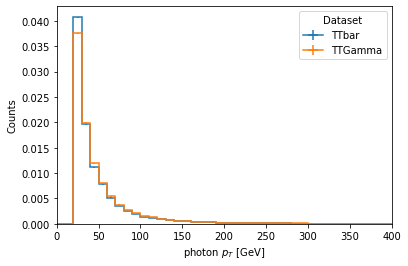

In [8]:
hist.plot1d(outputMC['photon_pt_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='$\\Delta R$', ylabel='Counts'>

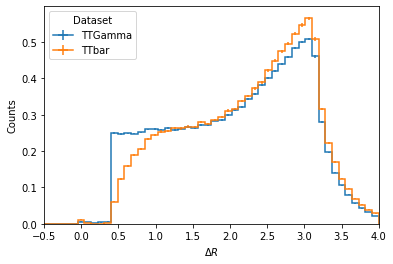

In [9]:
hist.plot1d(outputMC['deltaR_photon_lepton_hist'],overlay='dataset',stack=False,density=True)

<AxesSubplot:xlabel='$\\Delta R$', ylabel='Counts'>

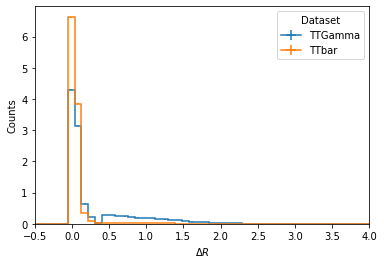

In [10]:
hist.plot1d(outputMC['deltaR_photon_jet_hist'],overlay='dataset',stack=False,density=True)

<AxesSubplot:xlabel='genPartFlav', ylabel='Counts'>

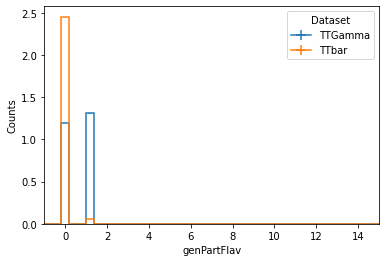

In [11]:
hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=False,density=True)

## Preprocessing data for training

In [12]:
print(np.array(outputMC['photon_count'].value))
print(np.array(outputMC['photon_count'].value).shape)#includes events w 0 pho; one entry per event not per pho
print(np.array(outputMC['photon_pt'].value).shape)

[0 0 0 ... 1 0 0]
(1768526,)
(950837,)


In [13]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    #'photon_count': np.array(outputMC['photon_count'].value),
    
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_genPartFlav
count,950837.000000,950837.000000,950837.000000,950837.000000,950837.000000,950837.000000,950837.000000,950837.000000,950837.000000,950837.000000,950837.000000
mean,49.575203,0.003868,0.010128,0.161182,0.749433,0.012393,0.767857,0.451332,2.154892,0.217426,0.368326
std,42.843124,0.772210,1.815265,0.161591,0.245689,0.003806,0.948009,0.598638,0.878554,0.403699,0.513648
min,20.000006,-1.444092,-3.141602,0.000000,0.088440,0.000196,0.000000,0.000000,0.000122,0.000000,0.000000
25%,25.604467,-0.623901,-1.562256,0.000000,0.574219,0.009224,0.077944,0.020645,1.436700,0.022985,0.000000
50%,35.087082,0.008705,0.010180,0.128418,0.791504,0.011040,0.486631,0.254656,2.287350,0.045382,0.000000
75%,55.912766,0.632568,1.584473,0.286133,0.947754,0.015175,1.095707,0.648748,2.880491,0.124659,1.000000
max,1208.737061,1.444092,3.141602,3.187500,20.515625,0.030731,31.009771,17.346630,4.904033,3.610590,13.000000


In [14]:
df['photon_genPartFlav'].value_counts()

0     602899
1     347748
13       190
Name: photon_genPartFlav, dtype: int64

In [15]:
### get rid of '13' ###

df = df[df['photon_genPartFlav'] != 13]
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_genPartFlav
count,950647.000000,950647.000000,950647.000000,950647.000000,950647.000000,950647.000000,950647.000000,950647.000000,950647.000000,950647.000000,950647.000000
mean,49.575130,0.003871,0.010079,0.161185,0.749422,0.012394,0.767835,0.451318,2.154896,0.217431,0.365801
std,42.843330,0.772220,1.815271,0.161593,0.245611,0.003806,0.947911,0.598579,0.878551,0.403706,0.481654
min,20.000006,-1.444092,-3.141602,0.000000,0.088440,0.000196,0.000000,0.000000,0.000122,0.000000,0.000000
25%,25.604441,-0.624023,-1.562256,0.000000,0.574219,0.009224,0.077979,0.020656,1.436700,0.022984,0.000000
50%,35.087105,0.008703,0.010113,0.128418,0.791504,0.011040,0.486668,0.254672,2.287350,0.045379,0.000000
75%,55.911900,0.632568,1.584229,0.286133,0.947754,0.015175,1.095689,0.648735,2.880502,0.124651,1.000000
max,1208.737061,1.444092,3.141602,3.187500,20.515625,0.030731,31.009771,17.346630,4.904033,3.610590,1.000000


In [16]:
df['photon_genPartFlav'].value_counts()

0    602899
1    347748
Name: photon_genPartFlav, dtype: int64

In [17]:
df.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_genPartFlav
0,79.276085,-0.075348,-2.450684,0.164062,0.435791,0.014397,0.047569,0.023416,2.238493,0.011533,0
1,29.967369,-0.605591,-1.234375,0.307617,0.895508,0.018478,2.158426,1.643791,3.142428,0.010509,0
2,66.590996,1.353516,2.028320,0.145020,0.519531,0.010857,0.257907,0.114259,3.289150,0.023781,0
3,33.870628,0.123627,0.236298,0.281250,0.405762,0.011902,0.931639,0.849794,2.786459,0.316535,0
4,22.035528,-0.709961,-2.442871,0.267578,0.511230,0.010422,1.443260,0.963974,1.247723,0.066349,0


In [18]:
### split into train, val, test datasets ###

In [19]:
X = np.array(df.drop(['photon_genPartFlav'],axis=1))
y = df['photon_genPartFlav']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(y_train.max())
print(y_train.min())

(570387, 10)
1
0


In [20]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

## Build & train model

In [21]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train_scaled, y_train, epochs=5, batch_size=128)

Epoch 1/5
4457/4457 [==============================] - 7s 2ms/step - loss: 0.1594 - accuracy: 0.9402
Epoch 2/5
4457/4457 [==============================] - 7s 2ms/step - loss: 0.1376 - accuracy: 0.9486
Epoch 3/5
4457/4457 [==============================] - 7s 2ms/step - loss: 0.1340 - accuracy: 0.9500
Epoch 4/5
4457/4457 [==============================] - 7s 2ms/step - loss: 0.1322 - accuracy: 0.9504
Epoch 5/5
4457/4457 [==============================] - 7s 1ms/step - loss: 0.1311 - accuracy: 0.9508


In [23]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.1321
Test accuracy: 0.95065


In [24]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

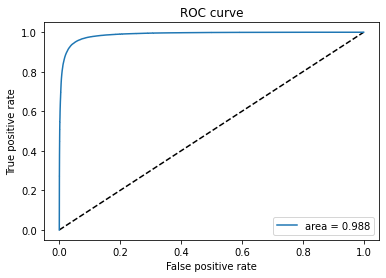

In [25]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [26]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

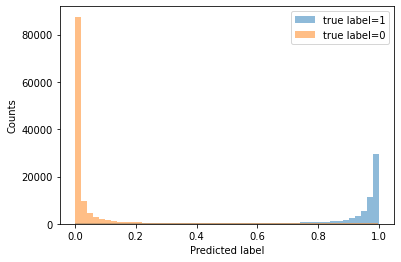

In [27]:
plt.hist(predTrue,bins=50,alpha=0.5,label='true label=1')
plt.hist(predFalse,bins=50,alpha=0.5,label='true label=0')

plt.xlabel('Predicted label')
plt.ylabel('Counts')
plt.title('')
plt.legend(loc='best')
plt.show()

### Evaluate the model on data

In [28]:
df_data = pd.DataFrame({
    'photon_pt': np.array(outputData['photon_pt'].value),
    'photon_eta': np.array(outputData['photon_eta'].value),
    'photon_phi': np.array(outputData['photon_phi'].value),
    'photon_hoe': np.array(outputData['photon_hoe'].value),
    'photon_r9': np.array(outputData['photon_r9'].value),
    'photon_sieie': np.array(outputData['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputData['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputData['photon_pfRelIso03_chg'].value),
    #'photon_count': np.array(outputData['photon_count'].value),
    
    'deltaR_photon_lepton': np.array(outputData['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputData['deltaR_photon_jet'].value),
})
df_data.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
count,4362.000000,4362.000000,4362.000000,4362.000000,4362.000000,4362.000000,4362.000000,4362.000000,4362.000000,4362.000000
mean,48.848301,-0.012361,-0.006382,0.224465,0.672342,0.013991,1.032235,0.597073,2.243940,0.065480
std,42.460018,0.796821,1.820470,0.155780,0.262536,0.003677,0.938122,0.614450,0.861288,0.152810
min,20.006186,-1.443604,-3.137695,0.000000,0.125732,0.005753,0.000000,0.000000,0.002021,0.000492
25%,24.972443,-0.677185,-1.591064,0.086304,0.502075,0.010866,0.405595,0.195077,1.571796,0.019602
50%,34.231617,-0.025288,0.014208,0.224365,0.672607,0.013924,0.773608,0.430241,2.380251,0.035087
75%,54.612218,0.639984,1.571838,0.344727,0.834839,0.016586,1.361839,0.819840,2.924950,0.061119
max,599.480103,1.441650,3.140137,1.355469,6.789062,0.026962,10.556261,7.809951,4.708734,2.276887


In [29]:
X_data = np.array(df_data)
X_data

array([[ 7.00269394e+01, -8.22265625e-01,  9.89990234e-01, ...,
         1.75632089e-01,  2.32386208e+00,  3.53635401e-02],
       [ 3.33345757e+01, -1.10888672e+00,  2.03710938e+00, ...,
         1.32351911e+00,  1.22960460e+00,  7.99723566e-02],
       [ 2.09460182e+01, -1.26489258e+00, -1.97241211e+00, ...,
         5.31339347e-01,  2.78469777e+00,  1.03643663e-01],
       ...,
       [ 3.07834072e+01, -5.79345703e-01,  1.15502930e+00, ...,
         3.63475710e-01,  1.29826260e+00,  4.49518859e-02],
       [ 1.39762054e+02,  2.14385986e-01,  6.39648438e-01, ...,
         5.26736259e-01,  2.28333640e+00,  1.94242507e-01],
       [ 1.15994385e+02,  9.77905273e-01,  3.12646484e+00, ...,
         4.92362350e-01,  1.49111974e+00,  5.01885675e-02]], dtype=float32)

In [30]:
scaler = StandardScaler()
X_data_scaled=scaler.fit_transform(X_data)

In [31]:
y_pred_data = model.predict(X_data_scaled)

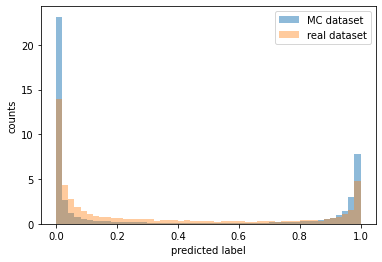

In [32]:
plt.hist(y_pred,bins=50,alpha=0.5,density=True,label="MC dataset")
plt.hist(y_pred_data,bins=50,alpha=0.4,density=True,label="real dataset")

plt.xlabel("predicted label")
plt.ylabel("counts")
plt.legend()
plt.show()